In [1]:
import copy
from collections import deque

from rdkit.Chem.Draw import IPythonConsole

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from rdkit import Chem
from rdkit.Chem import RWMol

from enviroment.ChemEnv import ChemEnv
from enviroment.Utils import mol_to_graph_full

from Rewards.rewards import SizeReward, SingleReward, FinalRewardModule

from models import BaseLine


Using backend: pytorch


In [39]:
from rdkit import Chem
from rdkit.Chem import rdBase
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import networkx as nx
from networkx.readwrite import cytoscape_data
import cyjupyter
from cyjupyter import Cytoscape
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import rdScaffoldNetwork
from urllib import parse


In [4]:
writer = SummaryWriter(f'./logs_test/_logs/tb')
reward_module = FinalRewardModule(writer, [SizeReward()])
env = ChemEnv(54,reward_module,mol_to_graph_full,writer)



In [5]:

class MolTree():
    """Class for holding molecular iteration tree
    """
    def __init__(self,root_mol: Chem.RWMol, idx: int):
        """init fn

        Args:
            root_mol (Chem.RWMol): the molecule to use as the node
        """
        self.root_mol = root_mol
        self.idx = idx    
        self.children = []
        
    def addChild(self, mol: Chem.RWMol):
        """add a child molecule

        Args:
            mol (Chem.RWMol): [description]
        """
        child = MolTree(mol)
        self.children.append(child)
        
    def addChildren(self, mols: 'list[Chem.RWMol]', i: int):
        """adds children molecules

        Args:
            mols (list[Chem.RWMol]): mols to add
            i (int): starting idx for node numbering

        Returns:
            int: number of children added
        """
        # self.children += list(map(lambda mol: MolTree(mol), mols))
        for j,mol in enumerate(mols):
            self.children.append(MolTree(mol,i+j))
            
        return len(self.children)
        

In [6]:

class Handler():
    """Class for handling model. inference and that sort of stuff"""
    def __init__(self, path: str, model: nn.Module, env: ChemEnv):
        """create handler insance

        Args:
            path (str): path to saved model
            model (nn.Module): model for params to be loaded into
            env ([type]): Chem environment
        """
        self.model = model
        # self.model.load(path)
        
        self.env = env

    def __get_n_best(self,mol: Chem.RWMol, n: int):
        """gets the top n most likely actions given mol

        Args:
            mol (Chem.RWMol): mol to set as state
            n (int): number of actions to return

        Returns:
            Torch.tensor: tensor containing the actions
        """
        # mol = Chem.RWMol(Chem.MolFromSmiles('CC-N'))
        self.env.assignMol(mol)
        obs = self.env.getObs()
        predictions = self.model(*obs) 
        _, actions = torch.topk(predictions,n)
        return actions

    def __run_actions(self, mol: Chem.RWMol, actions: 'list[int]'):
        """calculates new mols updated by actions

        Args:
            mol (Chem.RWMol): starting structure
            actions (list[int]): actions to take    

        Returns:
            list[Chem.RWMol]: newly generated molecules
        """
        new_mols = []
        for action in torch.squeeze(actions):
            action_int = int(action)
            mol_copy = copy.deepcopy(mol)
            self.env.assignMol(mol_copy)
            _,_,_,reward_dict = self.env.step(action_int)
            
            if reward_dict['step_reward'] > 0:
                new_mols.append(self.env.StateSpace)
        
        
        return new_mols
    
    def iterate(self, mol, n):
        """Expands the passed molecule by one step

        Args:
            mol (Chem.RWMol): base molecule to iterate on
            n (int): How many different one step iterations to make

        Returns:
            list[Chem.RWMol]: The mutated molecules
        """
        actions = self.__get_n_best(mol, n)
        mols = self.__run_actions(mol,actions)
        
        return mols
    
    def treeSearch(self,initial_mol: Chem.RWMol, width: int, size: int):
        """search chemical space around the initial molecule

        Args:
            initial_mol (Chem.RWMol): starting
            width (int): how many branches to make at each step
            size (int): total size of the tree

        Returns:
            [type]: [description]
        """
        
        molTree = MolTree(initial_mol,0)
        queue = deque([molTree])
        i = 1
        
        while queue:
            if size <= 0:
                break
            mol_node = queue.pop()
            children = self.iterate(mol_node.root_mol, width)
            j = mol_node.addChildren(children,i)
            i = i+j
            
            for child in mol_node.children:
                print(Chem.MolToSmiles(child.root_mol))
                queue.appendleft(child)
            
            size -= 1
            
            
        return molTree

    def inference():
        pass

In [122]:
def smi2svg(mol):
    try:
        Chem.rdmolops.Kekulize(mol)
    except:
        pass
    drawer = rdMolDraw2D.MolDraw2DSVG(690, 400)
    AllChem.Compute2DCoords(mol)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace("svg:", "")
    return svg

In [124]:
(smi2svg(mol))

"<?xml version='1.0' encoding='iso-8859-1'?>\n<svg version='1.1' baseProfile='full'\n              xmlns='http://www.w3.org/2000/svg'\n                      xmlns:rdkit='http://www.rdkit.org/xml'\n                      xmlns:xlink='http://www.w3.org/1999/xlink'\n                  xml:space='preserve'\nwidth='690px' height='400px' viewBox='0 0 690 400'>\n<!-- END OF HEADER -->\n<rect style='opacity:1.0;fill:#FFFFFF;stroke:none' width='690' height='400' x='0' y='0'> </rect>\n<path class='bond-0 atom-0 atom-1' d='M 31.3636,271.085 L 322.184,103.179' style='fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />\n<path class='bond-1 atom-1 atom-2' d='M 322.184,103.179 L 458.027,181.608' style='fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />\n<path class='bond-1 atom-1 atom-2' d='M 458.027,181.608 L 593.869,260.037' style='fill:none;fill-rule:even

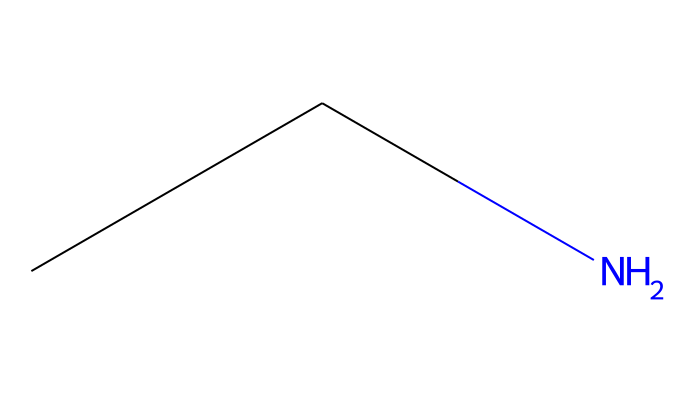

In [91]:
mol = Chem.MolFromSmiles("CC-N")
drawer = rdMolDraw2D.MolDraw2DSVG(690, 400)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
SVG(drawer.GetDrawingText())

In [159]:
def GraphFromMolTree(mol: MolTree):
    """Function for transforming a Molecule Tree to a nx Graph for use with cytoscape

    Args:
        mol (MolTree): Tree to be converted

    Returns:
        nx.graph.Graph: converted graph
    """
    g = nx.graph.Graph()
    queue = deque([mol])
    
    while queue:
        print('s')
        mol_tree = queue.pop()
        mol = mol_tree.root_mol
        if g.number_of_nodes() == 0:
            print('X')
            g.add_node(mol_tree.idx,mol = Chem.MolToSmiles(mol))#, img=smi2svg(mol), hac=mol.GetNumAtoms())
            
        for child in mol_tree.children:
            child_mol = child.root_mol
            g.add_node(child.idx, mol = Chem.MolToSmiles(child_mol))#, img = smi2svg(mol))
            g.add_edge(mol_tree.idx, child.idx)
            queue.appendleft(child)
        
        
    return g
    


In [207]:
model = BaseLine(54,300,17)
handler = Handler('af',model,env)
mol = Chem.RWMol(Chem.MolFromSmiles('CC-N'))
tree = handler.treeSearch(mol,3,12)
graph = GraphFromMolTree(tree)

CCN.S
C1CN1
C1CN1.S
C1CN1.c1ccccc1
SC1CN1
SC1CN1
S.SC1CN1
N1C2SC12
S.SC1CN1
N1C2SC12
SC1(S)CN1
SC1NC1S
N1C2SC12.S
N1C2SC12.c1ccnc1
B.N1C2SC12
SC1(S)CN1
SC1NC1S
N1C2SC12.S
N1C2SC12.c1ccnc1
B.N1C2SC12
S.SC1(S)CN1
SC12NC1S2
s
X
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s


In [220]:

cy_g = cytoscape_data(graph)
stobj=[
  {'style': [{'css': {
      'shape' : 'circle',
      'width':100,
      'height':100,
#       'border-color': 'rgb(0,0,0)',
#       'border-opacity': .5,
#       'border-width': 0.0,
#       'color': '#4579e8',
      'label': 'data(mol)',
      'font-size' : 40,
      'layout': {'name' : 'grid'}
#       'background-fit':'contain'
                    },
                      
    'selector': 'node'},
             
             
             
             
             
            {'css': {
                'width': 10.0,
                "target-arrow-shape": "triangle",
                "line-color": "#9dbaea",
                "target-arrow-color": "#9dbaea",
                "curve-style": "bezier"
            },
            'selector': 'edge'}
            ],
  }]

cyobj=Cytoscape(data=cy_g, visual_style=stobj[0]['style'])
cyobj


Cytoscape(data={'data': [], 'directed': False, 'multigraph': False, 'elements': {'nodes': [{'data': {'mol': 'C…

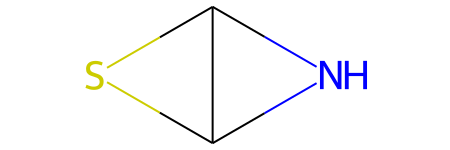

In [224]:
Chem.MolFromSmiles('N1C2SC12')

In [216]:
cy_g

{'data': [],
 'directed': False,
 'multigraph': False,
 'elements': {'nodes': [{'data': {'mol': 'CCN',
     'id': '0',
     'value': 0,
     'name': '0'}},
   {'data': {'mol': 'CCN.S', 'id': '1', 'value': 1, 'name': '1'}},
   {'data': {'mol': 'C1CN1', 'id': '2', 'value': 2, 'name': '2'}},
   {'data': {'mol': 'C1CN1.S', 'id': '3', 'value': 3, 'name': '3'}},
   {'data': {'mol': 'C1CN1.c1ccccc1', 'id': '4', 'value': 4, 'name': '4'}},
   {'data': {'mol': 'SC1CN1', 'id': '5', 'value': 5, 'name': '5'}},
   {'data': {'mol': 'SC1CN1', 'id': '6', 'value': 6, 'name': '6'}},
   {'data': {'mol': 'S.SC1CN1', 'id': '7', 'value': 7, 'name': '7'}},
   {'data': {'mol': 'N1C2SC12', 'id': '8', 'value': 8, 'name': '8'}},
   {'data': {'mol': 'S.SC1CN1', 'id': '9', 'value': 9, 'name': '9'}},
   {'data': {'mol': 'N1C2SC12', 'id': '10', 'value': 10, 'name': '10'}},
   {'data': {'mol': 'SC1(S)CN1', 'id': '11', 'value': 11, 'name': '11'}},
   {'data': {'mol': 'SC1NC1S', 'id': '12', 'value': 12, 'name': '12'}},


In [217]:
cyg = {'data' : [],
       'directed': True,
       'multigraph': False,
    
    'elements': {
    'nodes': [
      { 'data': { id: 0 } },
      { 'data': { id: 1 } },
      { 'data': { id: 2 } },
      { 'data': { id: 3 } },
      { 'data': { id: 4 } },
      { 'data': { id: 5 } },
      { 'data': { id: 6 } },
      { 'data': { id: 7 } },
      { 'data': { id: 8 } },
      { 'data': { id: 9 } },
      { 'data': { id: 10 } },
      { 'data': { id: 11 } },
      { 'data': { id: 12 } },
      { 'data': { id: 13 } },
      { 'data': { id: 14 } },
      { 'data': { id: 15 } },
      { 'data': { id: 16 } }
    ],
    'edges': [
      { 'data': { 'source': 0, 'target': 1 } },
      { 'data': { 'source': 1, 'target': 2 } },
      { 'data': { 'source': 1, 'target': 3 } },
      { 'data': { 'source': 4, 'target': 5 } },
      { 'data': { 'source': 4, 'target': 6 } },
      { 'data': { 'source': 6, 'target': 7 } },
      { 'data': { 'source': 6, 'target': 8 } },
      { 'data': { 'source': 8, 'target': 9 } },
      { 'data': { 'source': 8, 'target': 10 } },
      { 'data': { 'source': 11, 'target': 12 } },
      { 'data': { 'source': 12, 'target': 13 } },
      { 'data': { 'source': 13, 'target': 14 } },
      { 'data': { 'source': 13, 'target': 15 } }
    ]
  }}

In [218]:
cyobj=Cytoscape(data=cyg, visual_style=stobj[0]['style'])#, layout_name='circle')
cyobj

Cytoscape(data={'data': [], 'directed': True, 'multigraph': False, 'elements': {'nodes': [{'data': {<built-in …